In [2]:
import csv
import matplotlib.pyplot as plt
import os

In [3]:
def get_total_size(path, n_files):
    filenames = sorted(os.listdir(path))[:n_files]
    total_size = sum([os.path.getsize(path + filename) for filename in filenames])
    return total_size / (2**30)

def col_average(data):
    n_rows = len(data)
    n_cols = len(data[0])
    return [sum([data[i][j] for i in range(1, n_rows)]) / (n_rows - 1) for j in range(n_cols)]

def col_standard_deviation(data):
    n_rows = len(data)
    n_cols = len(data[0])
    mean = col_average(data)
    return [(sum([(data[i][j] - mean[j])**2 for i in range(1, n_rows)]) / (n_rows - 1))**0.5 for j in range(n_cols)]

def get_num_entries(path, n_files):
    filenames = sorted(os.listdir(path))
    num_entries = sum([uproot.open(path + filenames[i] + ":rootuple/CandidateTree").num_entries for i in range(n_files)])
    return num_entries

In [4]:
path = "../data/128_files/"

In [5]:
def plot(path, title, xlabel, ylabel, *args, plot_type=None, log_scale=False, log_base=2):
    data = []
    for i in range(0, len(args), 2):
        with open(args[i], "r") as f:
            data.append([[float(a) for a in row] for row in csv.reader(f)])
       
    for i in range(len(data)):
        if "size" in args[0]:
            for j in range(len(data[i])):
                data[i][j] = data[i][j][1:]
            data[i][0] = [get_total_size(path, int(n_files)) for n_files in data[i][0]]
        else:
            data[i][0][0] = 1
            
    plt.figure(figsize = (20, 10))
    plt.title(title, fontsize=32)
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    plt.xticks(range(0, 129, 8), fontsize=20)
#     plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if log_scale: plt.yscale("log", base=log_base)
    
    if plot_type == "speed-up":
        for j in range(len(data)):
            plt.plot(data[j][0], [col_average(data[j])[0] / runtime for runtime in col_average(data[j])], marker="o", label=args[2 * j + 1])
    elif plot_type == "ratio" and len(args) == 4:
        shorter_length = min(len(data[0][0]), len(data[1][0]))
        plt.plot(data[0][0][:shorter_length], [col_average(data[0])[i] / col_average(data[1])[i] for i in range(shorter_length)], marker="o")
        plt.hlines(y=1, xmin=0, xmax=129, color='red', linestyle ='dashed')
    elif plot_type == "errorbars":
        for j in range(len(data)):
            plt.errorbar(data[j][0], col_average(data[j]), yerr=col_standard_deviation(data[j]), fmt="-", ecolor="black", capsize=4, label=args[2 * j + 1])
    else:    
        for j in range(len(data)):
            plt.plot(data[j][0], col_average(data[j]), marker="o", label=args[2 * j + 1])
    
    plt.legend(prop={'size': 24})
    plt.show()

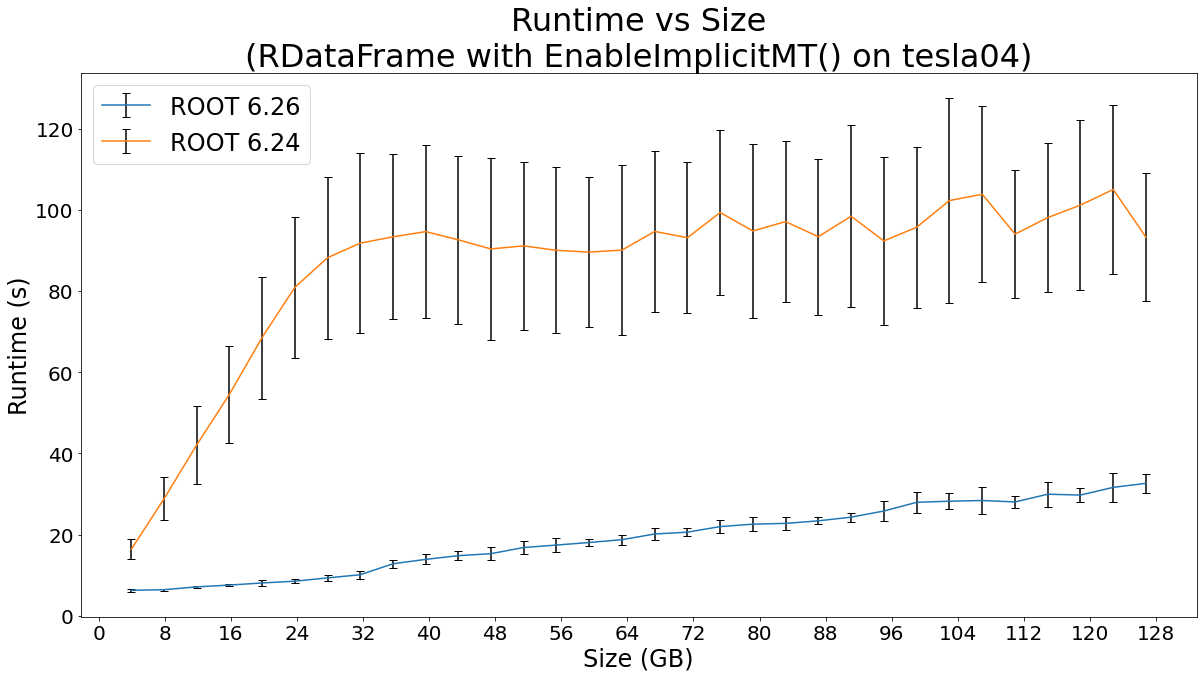

In [8]:
plot(path,
     'Runtime vs Size\n(RDataFrame with EnableImplicitMT() on tesla04)',
     'Size (GB)',
     'Runtime (s)',
     "runtime_tests_rdf/128_files/tesla04_remote/runtime_vs_size_128_4_20.csv",
     "ROOT 6.26",
     "runtime_tests_rdf/128_files/tesla04_remote_6_24/runtime_vs_size_128_4_20.csv",
     "ROOT 6.24",
#      log_scale=True,
#      log_base=2,
     plot_type="errorbars"
    )

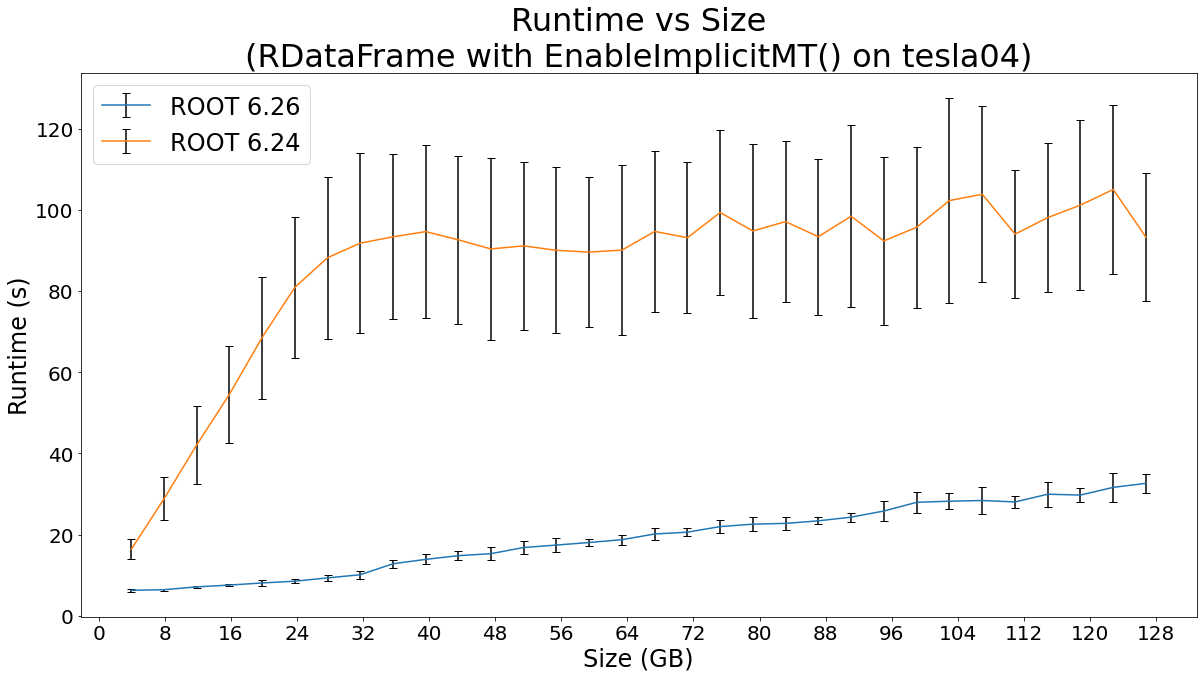

In [11]:
plot(path,
     'Runtime vs Size\n(RDataFrame with EnableImplicitMT() on tesla04)',
     'Size (GB)',
     'Runtime (s)',
     "runtime_tests_rdf/128_files/tesla04_remote/runtime_vs_size_128_4_20.csv",
     "ROOT 6.26",
     "runtime_tests_rdf/128_files/tesla04_remote_6_24/runtime_vs_size_128_4_20.csv",
     "ROOT 6.24",
#      log_scale=True,
#      log_base=2,
     plot_type="errorbars"
    )

In [18]:
import scipy

In [19]:
def linear(x, a, b):
    return a * x + b

In [20]:
def fit(path, csv_file):
    with open(csv_file, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
       
    if "size" in csv_file:
        for j in range(len(data)):
            data[j] = data[j][1:]
        data[0] = [get_total_size(path, int(n_files)) for n_files in data[0]]
    else:
        data[0][0] = 1
            
    return scipy.optimize.curve_fit(linear, data[0], col_average(data))


In [25]:
fit(path, "runtime_tests_uproot/128_files/wn-gpu-8-3-22/runtime_vs_size_mp_64_128_4_20.csv")

(array([0.10215951, 2.60035718]),
 array([[ 3.67388197e-06, -2.40058651e-04],
        [-2.40058651e-04,  2.06026088e-02]]))

In [22]:
0.96 * 128 + 0.3

123.17999999999999

In [26]:
0.1 * 128 + 2.6

15.4

In [27]:
123 / 15

8.2

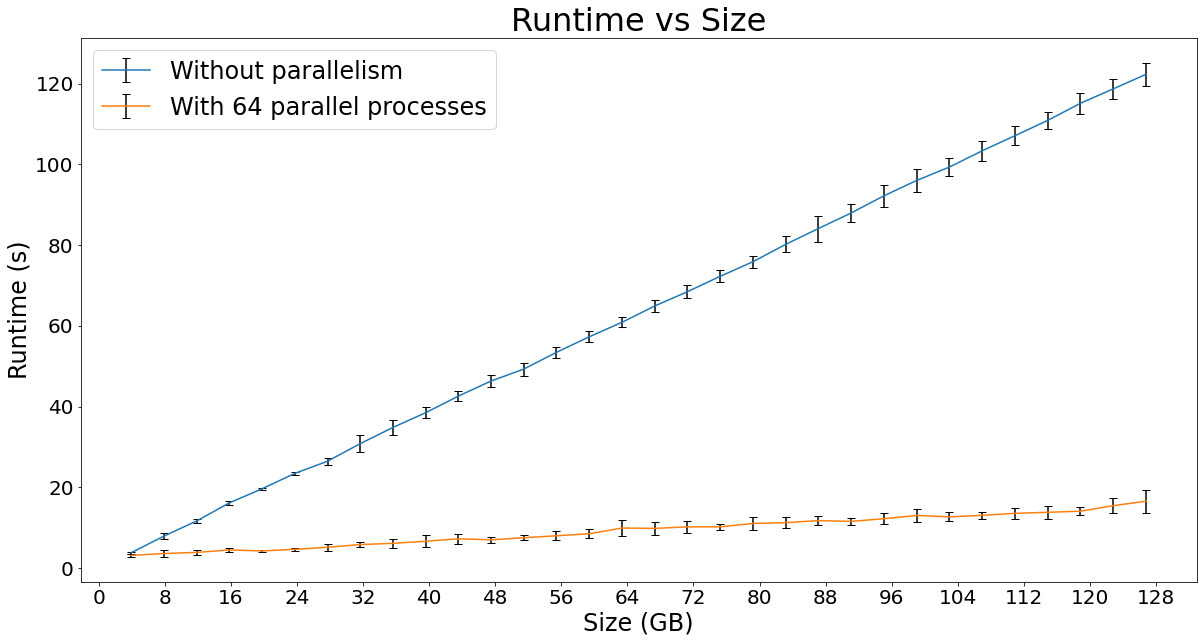

In [10]:
plot(path,
     'Runtime vs Size',
     'Size (GB)',
     'Runtime (s)',
     "runtime_tests_uproot/128_files/wn-gpu-8-3-22/runtime_vs_size_128_4_20.csv",
     "Without parallelism",
     "runtime_tests_uproot/128_files/wn-gpu-8-3-22/runtime_vs_size_mp_64_128_4_20.csv",
     "With 64 parallel processes",
     plot_type="errorbars"
    )